# Remove Glaciers from Shapefile

As the Snowmapper is not valid on glaciers, we need to remove them from our shapefiles of interest - same applies for SCA data

In [1]:
import os
import sys
import json

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


save_dir = "../../../../GIS/HRU_Gateway"

path_glaciers = "../../../../GIS/Glaciers/RGI2000-v7.0-G-13_central_asia/RGI2000-v7.0-G-13_central_asia.shp"

## Glacier Shapefile

                    rgi_id o1region o2region        glims_id  anlys_id  \
0  RGI2000-v7.0-G-13-00001       13    13-01  G067426E38743N    804440   
1  RGI2000-v7.0-G-13-00002       13    13-01  G067480E38714N    804446   
2  RGI2000-v7.0-G-13-00003       13    13-01  G067485E38713N    804448   
3  RGI2000-v7.0-G-13-00004       13    13-01  G067489E38714N    804451   
4  RGI2000-v7.0-G-13-00005       13    13-01  G067492E38714N    804453   

   subm_id             src_date     cenlon     cenlat  utm_zone  ...  \
0      752  2002-07-10T00:00:00  67.425881  38.743313        42  ...   
1      752  2002-07-10T00:00:00  67.479616  38.714583        42  ...   
2      752  2002-07-10T00:00:00  67.484971  38.713429        42  ...   
3      752  2002-07-10T00:00:00  67.489409  38.714494        42  ...   
4      752  2002-07-10T00:00:00  67.491937  38.713707        42  ...   

      zmin_m     zmax_m     zmed_m    zmean_m  slope_deg  aspect_deg  \
0  3693.8557  3783.9656  3727.2417  3728.6082  34.

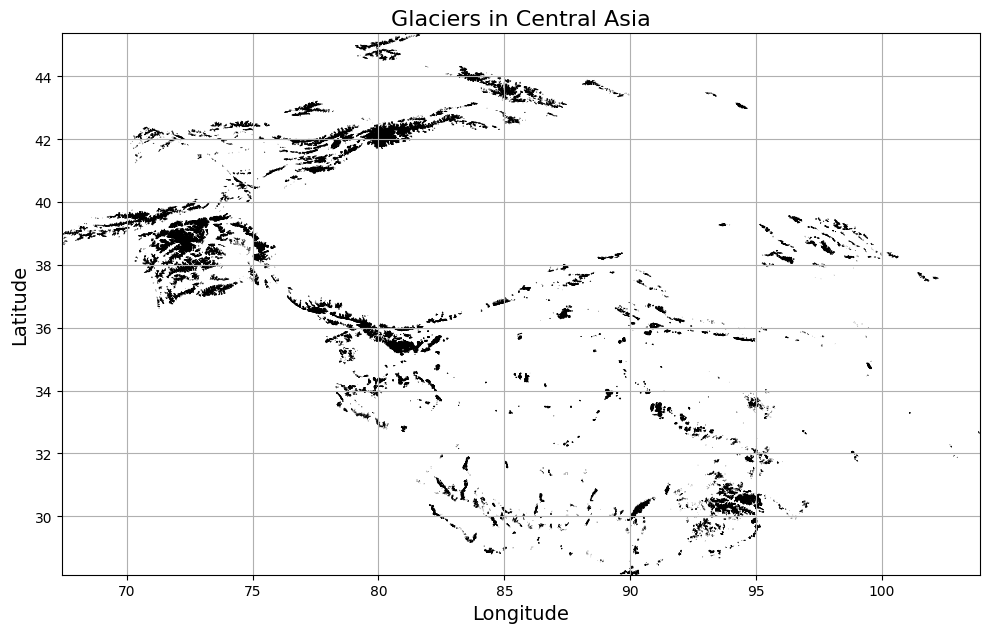

In [2]:
glaciers = gpd.read_file(path_glaciers)
print(glaciers.head())

import shapely

glaciers["geometry"] = glaciers["geometry"].apply(
    lambda geom: shapely.ops.transform(lambda x, y, z=None: (x, y), geom)
)

print(glaciers.head())
# plot glaciers
fig, ax = plt.subplots(figsize=(10, 10))
glaciers.plot(ax=ax, edgecolor="black", facecolor="none", lw=0.5)
ax.set_title("Glaciers in Central Asia", fontsize=16)
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)
ax.set_xlim(glaciers.total_bounds[[0, 2]])
ax.set_ylim(glaciers.total_bounds[[1, 3]])
plt.grid()
plt.tight_layout()
plt.show()

## Define Functions

In [3]:
def cut_glaciers(path_shp, glaciers):
    basins = gpd.read_file(path_shp)

    # Ensure both shapefiles are in the same CRS
    if basins.crs != glaciers.crs:
        glaciers = glaciers.to_crs(basins.crs)

    # Print info before processing
    print("-" * 20)
    print(f"Original basin count: {len(basins)}")
    print(f"Original total basin area: {basins.area.sum():.2f} km²")
    print(f"Glacier count: {len(glaciers)}")
    print(f"Total glacier area: {glaciers.area.sum():.2f} km²")
    print("-" * 20)

    # Dissolve glaciers for efficiency if there are many polygons
    dissolved_glaciers = glaciers.dissolve()
    # Remove glaciers from basins using spatial difference
    basins_without_glaciers = gpd.overlay(basins, dissolved_glaciers, how="difference")

    # Print results
    print(f"Basin count after removing glaciers: {len(basins_without_glaciers)}")
    print(
        f"Total basin area after removing glaciers: {basins_without_glaciers.area.sum():.2f} km²"
    )
    print(
        f"Area removed: {(basins.area.sum() - basins_without_glaciers.area.sum()):.2f} km²"
    )

    return basins_without_glaciers, dissolved_glaciers


def plot_basins_glaciers(basins, glaciers):
    # Improved visualization
    fig, ax = plt.subplots(figsize=(12, 10))

    # Create a better color scheme
    basin_color = "#78c679"  # Green for basins
    glacier_color = "#41b6c4"  # Blue for glaciers

    # Plot basins with clean borders
    basins.plot(ax=ax, color=basin_color, edgecolor="k", linewidth=0.1, alpha=0.7)

    if glaciers is not None:
        # Plot glaciers with slightly different style
        glaciers.plot(
            ax=ax, color=glacier_color, edgecolor="#225ea8", linewidth=0.3, alpha=0.8
        )

    # Improve labels and styling
    ax.set_title("Basin Extent and Glaciers", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)

    # Add legend
    from matplotlib.patches import Patch

    legend_elements = [
        Patch(facecolor=basin_color, edgecolor="#2b8cbe", alpha=0.7, label="Basins"),
        Patch(
            facecolor=glacier_color, edgecolor="#225ea8", alpha=0.8, label="Glaciers"
        ),
    ]
    ax.legend(handles=legend_elements, loc="lower right", fontsize=12)

    # Remove axis clutter
    ax.set_aspect("equal")
    # Dynamically set the extent based on the bounds of the basins being plotted
    bounds = basins.total_bounds  # [minx, miny, maxx, maxy]
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    plt.tight_layout()
    plt.show()


def process_hru(hru, save_dir, glaciers):
    path_to_basin = os.path.join(save_dir, hru)

    file_path = None

    # iterate over files and if shp file is found, cut glaciers
    for file in os.listdir(path_to_basin):
        if file.endswith(".shp"):
            file_path = os.path.join(path_to_basin, file)

    # Check if the file was found
    if file_path is None:
        print(f"No shapefile found in {path_to_basin}")
        return None, None

    # Read the shapefile
    basins = gpd.read_file(file_path)

    # cut glaciers
    basins_without_glaciers, dissolved_glaciers = cut_glaciers(file_path, glaciers)

    new_save_dir = os.path.join(save_dir, hru + "_no_glaciers")

    # Create the new directory if it doesn't exist
    if not os.path.exists(new_save_dir):
        os.makedirs(new_save_dir)

    # Save the new shapefile
    new_file_name = hru + "_no_glaciers.shp"
    new_file_path = os.path.join(new_save_dir, new_file_name)

    basins_without_glaciers.to_file(new_file_path)
    print(f"Saved new shapefile to {new_file_path}")

    # plot basins and glaciers
    plot_basins_glaciers(basins_without_glaciers, dissolved_glaciers)

    return basins_without_glaciers

## KGZ ML SHP

--------------------
Original basin count: 63
Original total basin area: 18.13 km²
Glacier count: 75613
Total glacier area: 5.14 km²
--------------------


/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_67188/609206932.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"Original total basin area: {basins.area.sum():.2f} km²")
/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_67188/609206932.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"Total glacier area: {glaciers.area.sum():.2f} km²")


Basin count after removing glaciers: 63
Total basin area after removing glaciers: 17.54 km²
Area removed: 0.58 km²


/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_67188/609206932.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"Total basin area after removing glaciers: {basins_without_glaciers.area.sum():.2f} km²")
/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_67188/609206932.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"Area removed: {(basins.area.sum() - basins_without_glaciers.area.sum()):.2f} km²")


Saved new shapefile to ../../../../GIS/HRU_Gateway/00003_no_glaciers/00003_no_glaciers.shp


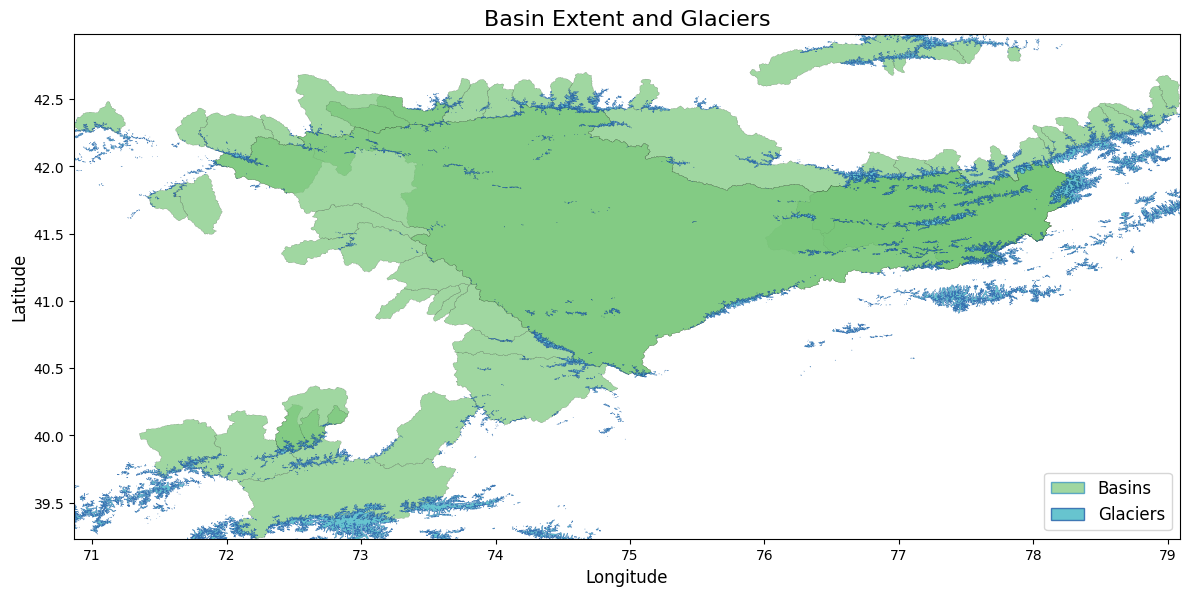

    CODE   name  Z                                           geometry
0  15013  15013  0  POLYGON ((78.98792 42.67796, 78.98778 42.67707...
1  15016  15016  0  MULTIPOLYGON (((78.93336 42.59639, 78.93307 42...
2  15020  15020  0  MULTIPOLYGON (((78.53308 42.47151, 78.53280 42...
3  15022  15022  0  MULTIPOLYGON (((78.61680 42.47074, 78.61666 42...
4  15025  15025  0  MULTIPOLYGON (((78.48250 42.45055, 78.48223 42...


In [18]:
hru = "00003"

# Call the function to process the HRU
basins_new = process_hru(hru, save_dir, glaciers)

print(basins_new.head())

## Elevation Band 500m KGZ

--------------------
Original basin count: 441
Original total basin area: 18.13 km²
Glacier count: 75613
Total glacier area: 5.14 km²
--------------------


/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_67188/609206932.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"Original total basin area: {basins.area.sum():.2f} km²")
/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_67188/609206932.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"Total glacier area: {glaciers.area.sum():.2f} km²")


Basin count after removing glaciers: 441
Total basin area after removing glaciers: 17.54 km²
Area removed: 0.58 km²


/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_67188/609206932.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"Total basin area after removing glaciers: {basins_without_glaciers.area.sum():.2f} km²")
/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_67188/609206932.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"Area removed: {(basins.area.sum() - basins_without_glaciers.area.sum()):.2f} km²")


Saved new shapefile to ../../../../GIS/HRU_Gateway/KGZ500m_no_glaciers/KGZ500m_no_glaciers.shp


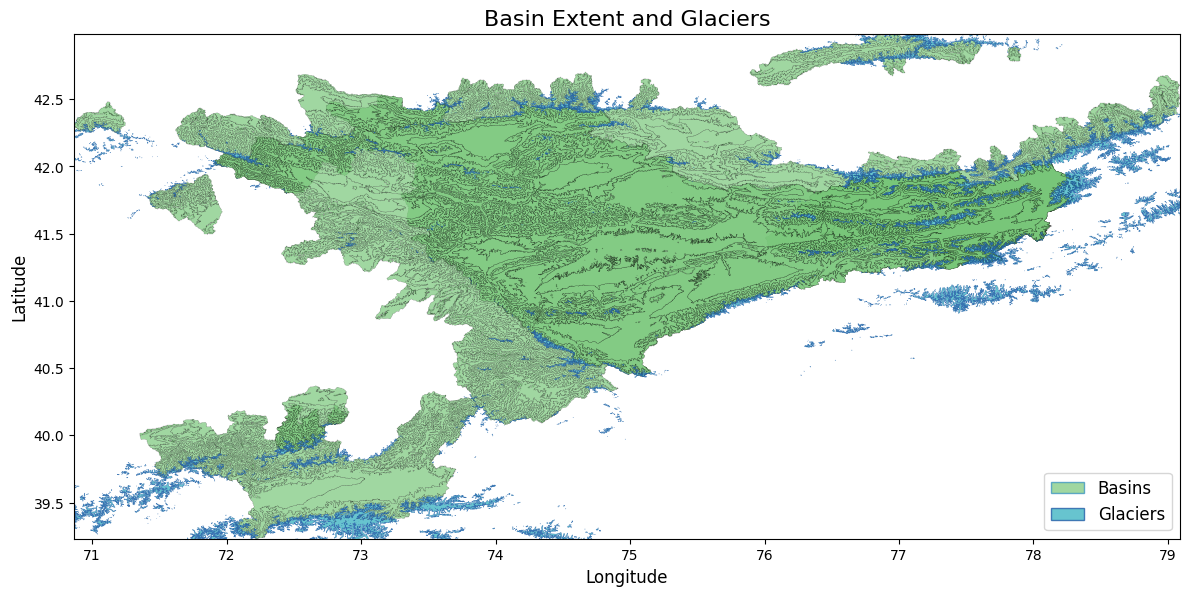

    CODE  elevation_  relative_a     name  Z  \
0  15013         3.0    0.001047  15013_3  1   
1  15013         6.0    0.350801  15013_6  1   
2  15013         4.0    0.229297  15013_4  1   
3  15013         7.0    0.160801  15013_7  1   
4  15013         5.0    0.257222  15013_5  1   

                                            geometry  
0  POLYGON ((78.92333 42.65405, 78.92388 42.65405...  
1  MULTIPOLYGON (((79.03050 42.64092, 79.03269 42...  
2  MULTIPOLYGON (((78.95286 42.67209, 78.95395 42...  
3  MULTIPOLYGON (((79.05401 42.55562, 79.05401 42...  
4  POLYGON ((78.98567 42.67811, 78.98785 42.67811...  


In [19]:
hru = "KGZ500m"

# Call the function to process the HRU
basins_new = process_hru(hru, save_dir, glaciers)

print(basins_new.head())

## TJK Shapefiles

--------------------
Original basin count: 17
Original total basin area: 11.41 km²
Glacier count: 75613
Total glacier area: 5.14 km²
--------------------


/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_20015/609206932.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"Original total basin area: {basins.area.sum():.2f} km²")
/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_20015/609206932.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"Total glacier area: {glaciers.area.sum():.2f} km²")


Basin count after removing glaciers: 17
Total basin area after removing glaciers: 10.31 km²
Area removed: 1.10 km²


/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_20015/609206932.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"Total basin area after removing glaciers: {basins_without_glaciers.area.sum():.2f} km²")
/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_20015/609206932.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"Area removed: {(basins.area.sum() - basins_without_glaciers.area.sum()):.2f} km²")


Saved new shapefile to ../../../../GIS/HRU_Gateway/00004_no_glaciers/00004_no_glaciers.shp


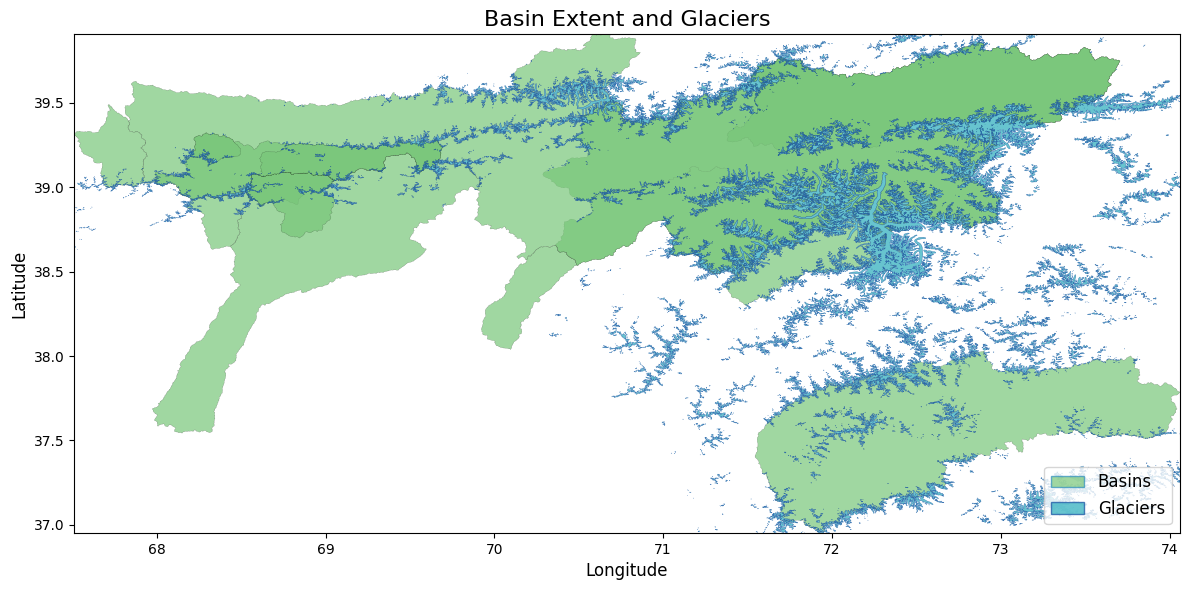

    CODE   name  Z                                           geometry
0  16205  16205  0  MULTIPOLYGON (((70.58505 39.90591, 70.58503 39...
1  17050  17050  0  MULTIPOLYGON (((73.77056 38.00040, 73.77050 37...
2  17077  17077  0  POLYGON ((70.36145 38.65806, 70.36260 38.65805...
3  17082  17082  0  MULTIPOLYGON (((72.87461 39.85949, 72.87578 39...
4  17100  17100  0  MULTIPOLYGON (((72.87461 39.85949, 72.87578 39...


In [4]:
hru = "00004"

# Call the function to process the HRU
basins_new = process_hru(hru, save_dir, glaciers)

print(basins_new.head())